In [5]:
import os
os.chdir("..")

In [45]:
from lib.utils import load_dataset, train_val_test_split, remove_dir
from lib.datasets import GeorgeDataset, get_george_loaders
from lib.trainer import ClassifierModel
from lib.metrics import accuracy_value, roc_auc_value
from lib.metrics import f1_value, precision_value, recall_value
from lib.show import val_lr_curves, show_roc_curve, show_fp_fn

In [7]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from efficientnet_pytorch import EfficientNet

import logging
logging.getLogger().setLevel(logging.INFO)

## Подготовка данных

Загрузим датасет. В конце мы его удалим, т.к. права на картинки кому-нибудь все-таки принадлежат.

In [8]:
geo_dir = load_dataset("data/georges.csv", "georges")

100%|██████████| 2630/2630 [04:01<00:00, 10.88it/s]


In [9]:
nongeo_dir = load_dataset("data/non_georges.csv", "non_georges")

100%|██████████| 3358/3358 [03:03<00:00, 18.26it/s]


Зафиксируем сиды для воспроизводимости кода. Я не стал фиксировать сиды у cuda для скорости.

In [10]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

Разделим датасет на трейн, валидацию и тест. Т.к. все картинки можно считать независимыми, стратификация не нужна.

In [11]:
train, val, test = train_val_test_split([geo_dir, nongeo_dir], 0.7, 0.2)

Обучим 2 модельки: EfficientNet-B2 (9.2 млн параметров) и Resnet-50 (26 млн параметров). Первую можно считать SOTA на задачах бинарной классификации изображений (наряду с низшими версиями EfficinetNet и MobileNet), вторая нужна для сравнения с первой и для демострации полиморфизма реализованного класса ClassifierModel.

Подбор гиперпараметров реализовывался вручную для простоты. Гиперпараметры, оптимизиаторы и lr шедулеры одни и те же для обеих моделей, опять же для простоты. 

Будем тренировать по 25 эпох с небольшим learning rate.



In [12]:
eff_models = [
    "efficientnet-b0",
    "efficientnet-b1",
    "efficientnet-b2",
    "efficientnet-b3",
    "efficientnet-b4",
]
eff_batch_sizes = [150, 100, 64, 50, 20]
eff_image_sizes = [224, 240, 260, 300, 380]
model_index = 2

efn_params = {
    "model": eff_models[model_index],
    "lr": 0.00005,
    "batch_size": eff_batch_sizes[model_index],
    "n_workers": 8,
    "n_epochs": 25,
    "n_classes": 2,
    "input_size": eff_image_sizes[model_index],
    "tta_attempts": 30,
    "name": "EfficientNet-B2-fn-tune",
}

if torch.cuda.is_available():
    efn_params["device"] = torch.device("cuda:0")
    logging.info(f"Running on {torch.cuda.get_device_name()}")
else:
    efn_params["device"] = torch.device("cpu")
    logging.info("Running on a CPU")

resn_params = {
    "model": "resnet50",
    "lr": 0.00005,
    "batch_size": 64,
    "n_workers": 8,
    "n_epochs": 25,
    "n_classes": 2,
    "input_size": 224,
    "tta_attempts": 30,
    "name": "ResNet-50-fn-tune",
    "device": efn_params["device"],
}

INFO:root:Running on Tesla T4


С помощью albumentations получим аугментации изображений и инициализируем Dataloader для каждой из моделей.

In [13]:
efn_loaders_dict = get_george_loaders(
    train,
    val,
    test,
    efn_params["input_size"],
    efn_params["batch_size"],
    efn_params["n_workers"],
    efn_params["tta_attempts"],
)
resn_loaders_dict = get_george_loaders(
    train,
    val,
    test,
    resn_params["input_size"],
    resn_params["batch_size"],
    resn_params["n_workers"],
    resn_params["tta_attempts"],
)

## Тренировка моделей

Скачаем модели. Для EfficientNet нужно установить дополнительный пакет (он добавлен в конфиг poetry).

In [14]:
efn_model = EfficientNet.from_pretrained(efn_params["model"])
resn_model = getattr(models, resn_params["model"])(pretrained=True)

Loaded pretrained weights for efficientnet-b2


Инициализируем оптимизаторы, шедулеры и лосс. Формально они одинаковы, но мы их разделили для унифицированности кода.  

In [15]:
efn_optimizer = optim.Adam(efn_model.parameters(), lr=efn_params["lr"])
efn_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    efn_optimizer, mode="max", patience=1, cooldown=1
)
efn_criterion = nn.CrossEntropyLoss()

resn_optimizer = optim.Adam(resn_model.parameters(), lr=resn_params["lr"])
resn_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    resn_optimizer, mode="max", patience=1, cooldown=1
)
resn_criterion = nn.CrossEntropyLoss()

Используем нашу обертку под модель. Последний аргумент - название модели для сохранения версии с наилучшим accuracy.

In [16]:
eff_net = ClassifierModel(efn_model, efn_params["device"], 2, efn_params["name"])
res_net = ClassifierModel(resn_model, resn_params["device"], 2, resn_params["name"])


Наконец, тренируем модели. 

In [17]:
efn_history = eff_net.train(
    efn_loaders_dict,
    efn_criterion,
    efn_optimizer,
    efn_scheduler,
    early_stopping=5,
    n_epochs=efn_params["n_epochs"],
)

INFO:root:Starting training:
            Epochs:          25
            Batch size:      64
            Learning rate:   5e-05
            Training size:   66
            Validation size: 19
            Best model path: models/EfficientNet-B2-fn-tune.pt
            Device:          cuda
        
INFO:root:Epoch 1/25
100%|██████████| 19/19 [00:15<00:00,  1.22it/s]
INFO:root:
                Train loss:      0.019264
                Val loss:        0.015459
                Train accuracy:  0.691243
                Val accuracy:    0.829716
            
INFO:root:Epoch 2/25
100%|██████████| 19/19 [00:15<00:00,  1.22it/s]
INFO:root:
                Train loss:      0.013650
                Val loss:        0.009450
                Train accuracy:  0.823431
                Val accuracy:    0.884808
            
INFO:root:Epoch 3/25
100%|██████████| 19/19 [00:15<00:00,  1.22it/s]
INFO:root:
                Train loss:      0.009961
                Val loss:        0.007359
                

In [18]:
resn_history = res_net.train(
    resn_loaders_dict,
    resn_criterion,
    resn_optimizer,
    resn_scheduler,
    early_stopping=5,
    n_epochs=resn_params["n_epochs"],
)

INFO:root:Starting training:
            Epochs:          25
            Batch size:      64
            Learning rate:   5e-05
            Training size:   66
            Validation size: 19
            Best model path: models/ResNet-50-fn-tune.pt
            Device:          cuda
        
INFO:root:Epoch 1/25
100%|██████████| 19/19 [00:14<00:00,  1.32it/s]
INFO:root:
                Train loss:      0.012172
                Val loss:        0.006446
                Train accuracy:  0.817227
                Val accuracy:    0.924875
            
INFO:root:Epoch 2/25
100%|██████████| 19/19 [00:14<00:00,  1.32it/s]
INFO:root:
                Train loss:      0.006322
                Val loss:        0.005686
                Train accuracy:  0.918874
                Val accuracy:    0.936561
            
INFO:root:Epoch 3/25
100%|██████████| 19/19 [00:14<00:00,  1.31it/s]
INFO:root:
                Train loss:      0.004601
                Val loss:        0.005193
                Train 

## Анализ результатов

Для начала посмотрим на кривые валидации и трейна, полученные в ходе обучения. Также посмотрим, как изменялся learning rate.

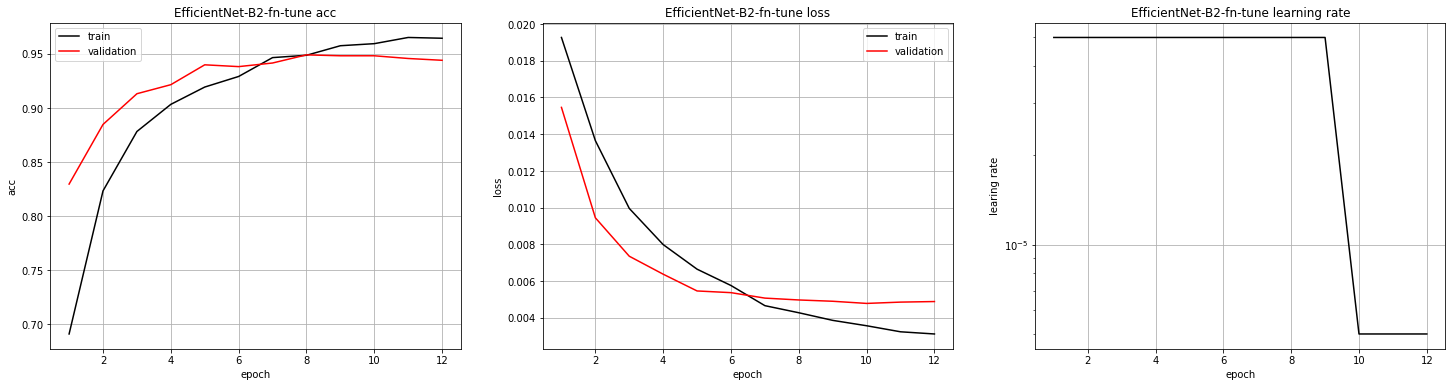

In [46]:
val_lr_curves(efn_history, efn_params["name"])

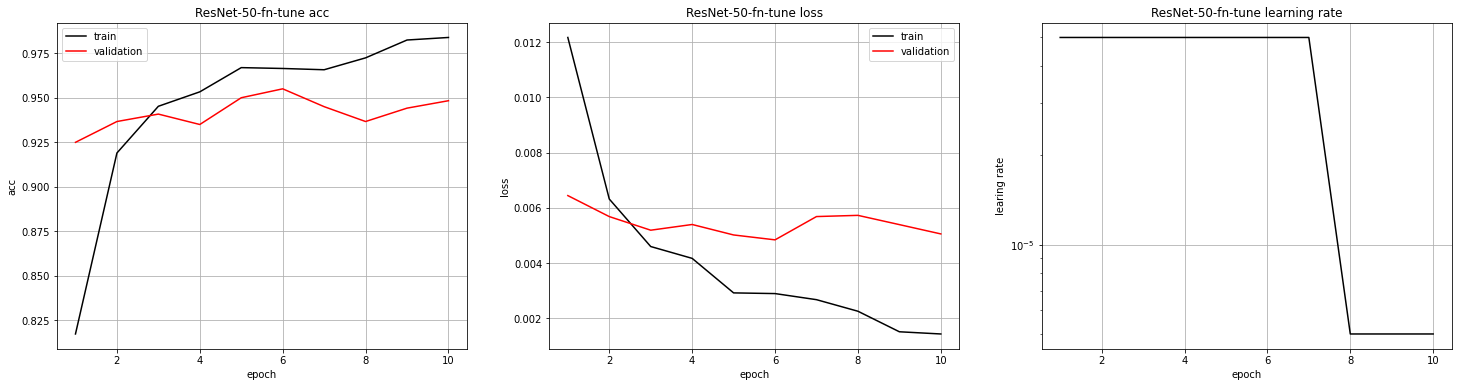

In [47]:
val_lr_curves(resn_history, resn_params["name"])

Как видно, вторая моделька сильно переобучилась (действительно, у нее практически в 3 раза больше параметров). 

In [20]:
efn_preds = eff_net.predict(efn_loaders_dict["test"])
efn_preds_proba = eff_net.predict_proba(efn_loaders_dict["test"])
efn_labels = efn_loaders_dict["test"].dataset.get_targets()

resn_preds = res_net.predict(resn_loaders_dict["test"])
resn_preds_proba = res_net.predict_proba(resn_loaders_dict["test"])
resn_labels = resn_loaders_dict["test"].dataset.get_targets()

INFO:root:
            TTA attempts:       30
            number of samples:  599
        
100%|██████████| 281/281 [04:12<00:00,  1.11it/s]
INFO:root:
            TTA attempts:       30
            number of samples:  599
        
100%|██████████| 281/281 [04:12<00:00,  1.11it/s]
INFO:root:
            TTA attempts:       30
            number of samples:  599
        
100%|██████████| 281/281 [03:58<00:00,  1.18it/s]
INFO:root:
            TTA attempts:       30
            number of samples:  599
        
100%|██████████| 281/281 [03:58<00:00,  1.18it/s]


Посчитаем основные метрики задачи классификации и выведем ROC кривые.

In [21]:
print(
    f"""
       EfficientNet-B0 model
       accuracy = {accuracy_value(efn_preds, efn_labels)}
       precision = {precision_value(efn_preds, efn_labels)}
       recall = {recall_value(efn_preds, efn_labels)}
       f1 score = {f1_value(efn_preds, efn_labels)}
       ROC AUC score = {roc_auc_value(efn_preds_proba[:, 1], efn_labels)}
"""
)
print(
    f"""
       ResNet-50 model
       accuracy = {accuracy_value(resn_preds, resn_labels)}
       precision = {precision_value(resn_preds, resn_labels)}
       recall = {recall_value(resn_preds, resn_labels)}
       f1 score = {f1_value(resn_preds, resn_labels)}
       ROC AUC score = {roc_auc_value(resn_preds_proba[:, 1], resn_labels)}
"""
)


       EfficientNet-B0 model
       accuracy = 0.9565943479537964
       precision = 0.9494163424124513
       recall = 0.9494163424124513
       f1 score = 0.9494163424124513
       ROC AUC score = 0.9869274353198171


       ResNet-50 model
       accuracy = 0.9582637548446655
       precision = 0.9715447154471545
       recall = 0.9299610894941635
       f1 score = 0.9502982107355866
       ROC AUC score = 0.9843789109609303



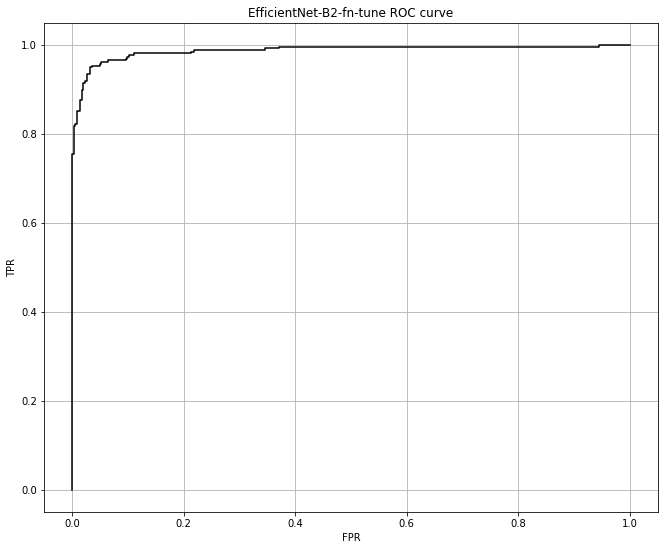

In [22]:
show_roc_curve(efn_preds_proba[:, 1], efn_labels, efn_params["name"])

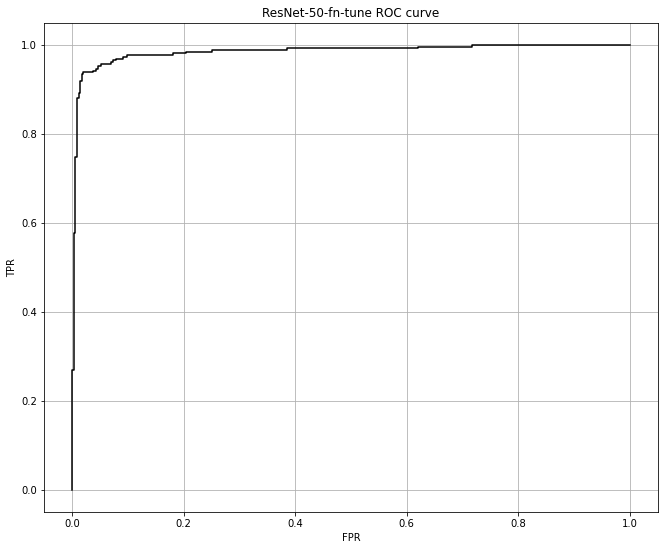

In [23]:
show_roc_curve(resn_preds_proba[:, 1], resn_labels, resn_params["name"])

Посмотрим на неверно классифицированные изображения для каждой из моделей.

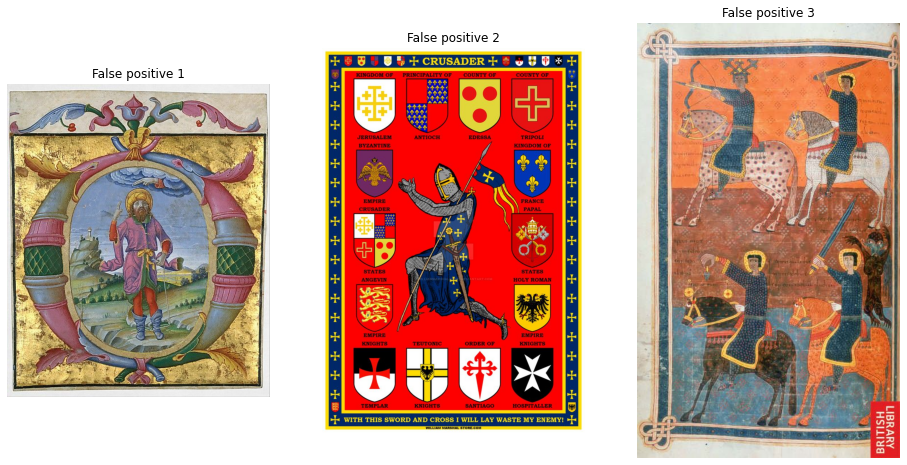

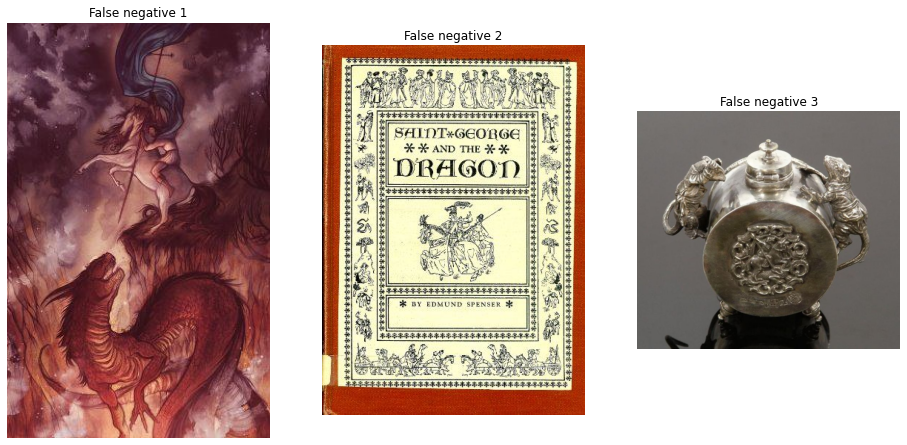

In [24]:
show_fp_fn(efn_loaders_dict["test"], efn_preds, efn_labels, 3)

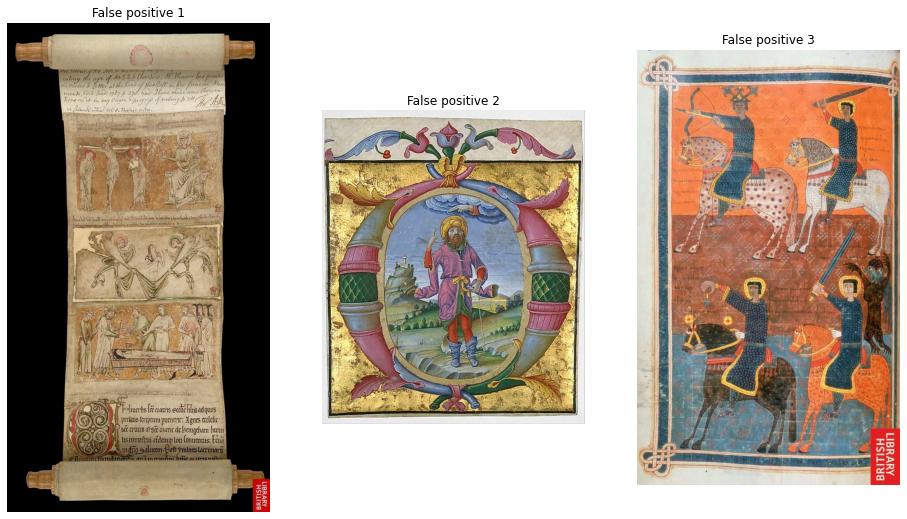

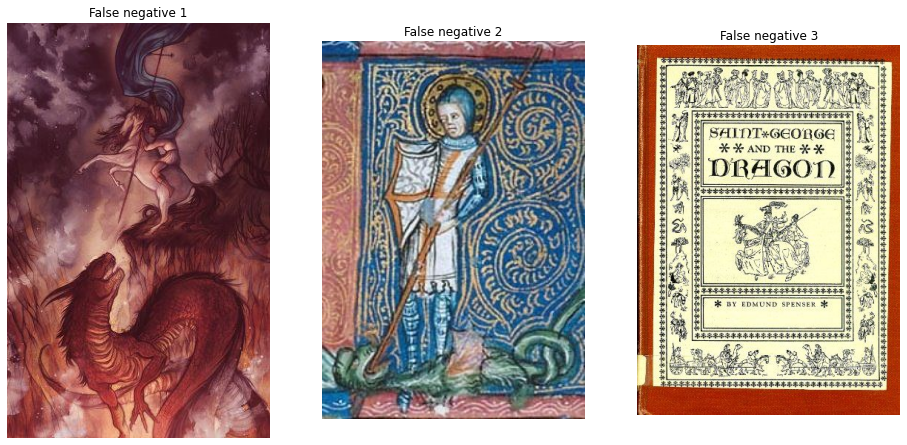

In [25]:
show_fp_fn(resn_loaders_dict["test"], resn_preds, resn_labels, 3)

Наконец, когда у нас есть модели, удалим изображения.

In [26]:
remove_dir("data/images")